In [ ]:
%pip install yfinance

import yfinance as yf

In [ ]:
import ipywidgets as widgets

ticker = widgets.Dropdown(
    options=[('S&P500', '^GSPC'), ('Google', 'GOOG'), ('Apple', 'AAPL')],
    description='Stock:',
    disabled=False,
)

display(ticker)

Dropdown(description='Stock:', options=(('S&P500', '^GSPC'), ('Google', 'GOOG'), ('Apple', 'AAPL')), value='^G…

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

stock_history = yf.Ticker(ticker.value)
stock_history = stock_history.history(period="max")
del stock_history["Stock Splits"]
stock_history = stock_history.loc["1970-01-01":].copy()
stock_history["Tomorrow"] = stock_history["Close"].shift(-1)
stock_history["isUp"] = (stock_history["Tomorrow"] > stock_history["Close"]).astype(int)
stock_history = stock_history.fillna(0)

model = RandomForestClassifier(n_estimators=100)

train = stock_history.iloc[:-250]
test = stock_history.iloc[-250:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["isUp"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

preds_probab = model.predict_proba(test[predictors])
preds_probab = pd.DataFrame(preds_probab,  index=test.index)


0.5714285714285714


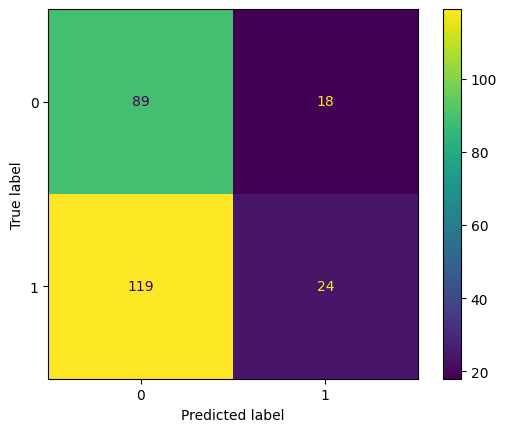

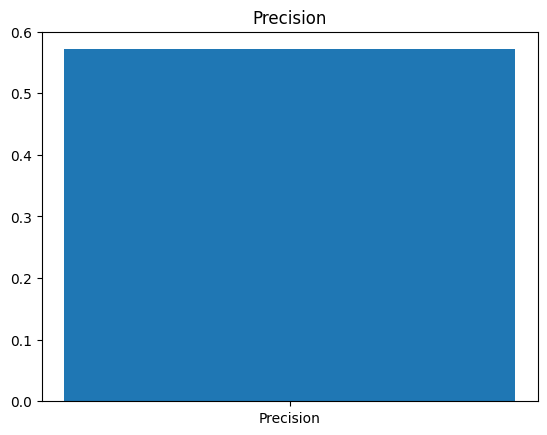

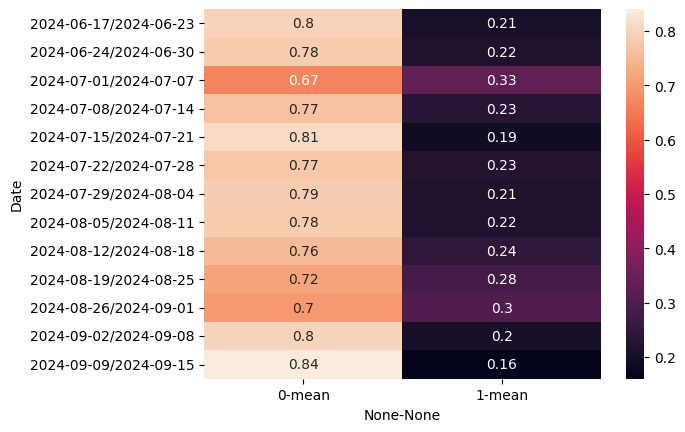

In [ ]:
from sklearn.metrics import precision_score,confusion_matrix, ConfusionMatrixDisplay
from seaborn import heatmap
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

cm = confusion_matrix(test["isUp"], preds)

print(precision_score(test["isUp"], preds))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

precision = precision_score(test["isUp"], preds)
plt2.bar(["Precision"], precision)
plt2.title("Precision")
plt2.show()

last_month_data = preds_probab.iloc[-60:].tz_localize(None)
grouped_data = last_month_data.groupby(last_month_data.index.to_period("W")).agg(["mean"])
heatmap = heatmap(grouped_data, annot=True)
plt.show()


In [ ]:
from google.colab import files

stock_history.to_csv("stock_history.csv", sep=",")
files.download('stock_history.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import display, Javascript

date = widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

date.add_class("start-date")

script = Javascript("\
                const query = '.start-date'; \
                var today = new Date(); \
                var yesterday = new Date(); \
                yesterday.setDate(today.getDate() - 1); \
                var endOfTrainingSet = new Date(); \
                endOfTrainingSet.setDate(today.getDate() - 14); \
                document.querySelector(query).setAttribute('min', endOfTrainingSet.toLocaleDateString('en-CA')); \
                document.querySelector(query).setAttribute('max', yesterday.toLocaleDateString('en-CA')); \
        ")

display(date)
display(script)

DatePicker(value=None, description='Pick a Date', _dom_classes=('start-date',))

<IPython.core.display.Javascript object>

In [ ]:
from datetime import datetime, timedelta
import math

date_format = "%Y-%m-%d"
date_object = datetime.strptime(str(date.value), date_format).date()

if  date_object is None:
    raise Exception("Invalid date")

if  date_object < (datetime.today() - timedelta(14)).date():
    raise Exception("Date is within the training set")

if date_object > (datetime.today()).date():
    raise Exception("Date is outside of the test set")

try:
  predict_record = str(date_object.strftime('%Y-%m-%d') + " 00:00:00-04:00")

  record = stock_history.loc[predict_record].to_frame().T
  record = record.fillna(0)

  single_pred = model.predict(record[predictors])
  single_probab = model.predict_proba(record[predictors])
  print("Prediction of stock going up: " + str(single_pred[0] == 1))
  print("Probability of stock going up: " + str(single_probab[0][1]))
  if not math.isnan(float(record['Tomorrow'].values[0])):
    print("Result of stock going up: " + str((record['isUp'] == 1).values[0]))
  else:
    print("Result of tomorrow's closing not available.")

  print("Closing values of today's stock: ")
  print(record)
except KeyError:
  print("Data not found for date entered. Potentially a non-trading day.")
except ValueError:
  print("Data not found for date entered. Potentially a non-trading day.")
except:
  print("Error")


Prediction of stock going up: True
Probability of stock going up: 0.62
Result of stock going up: False
Closing values of today's stock: 
                                  Open         High          Low        Close  \
2024-09-09 00:00:00-04:00  5442.069824  5484.200195  5434.490234  5471.049805   

                                 Volume  Dividends  Tomorrow  isUp  
2024-09-09 00:00:00-04:00  2.563088e+09        0.0       0.0   0.0  
